Preliminary notebook exploring processing strategies for specific stimulus epochs of V1DD-2P dataset.
Specficially, we will examine the popw will look at the responses to  `drifting_gratings_full`, `spontaneous` and `natural_movies`,

**Initial steps**
- Just focus on volumes 2 and 3 (the "good" volumes)
- Scaling the dF/F traces using a min-max scaler
  - Maybe consider some robust min-max scaling, e.g. between the 1st and 99th percentile
- Bin at the 2s timebins of `drifting_gratings_full`
    - Stringer et al. 2019 used a 1.2-1.3s binning for their analyses, so this is on a similar order.

**Sumary**
- Binned the data for the first epoch of `drifting_gratings_full`
- This data should be in a good preliminary form for Arun to begin working on

*Additional notes*
- Here, just looking at volume 2, one of the good volumes
- Verified robust min-max scaling strategy for dF/F normalization, standard scaling for behavioral variables

**Next steps**
- [Arun] Begin identifying single vs population level correlation to identify soloists vs. choristers in this epoch
- [Libby]: Streamline the processing pipeline so that we can easily apply to other epochs
  - In particular, the binning is a bit clunky and relies on the `drifitng_gratings_full` having defined stimulus times
- [Libby]: Test out different ways to regress out behavior; definitely seems like a big factor
  - Standard scale the behavior variables (by stimulus epoch)
  - Ridge regresssion!!! Extreme collinearity between pupil and running.
  - Vergil: Try out a behavioral gain (multiplicative) modulation. Let A and B be the two behavioral traces. Construct a 3rd variable, $x_C = x_A x x_B$. Now, fit a linear (ridge) regression to the 3 variables. Residuals consist of (pay close attention!!!!:  $$y_\textrm{resid} = [y_A - \hat{y}_A, y_B - \hat{y}_B, y_C/\hat{y}_C]$$
    - Gain modulation of behavioral variables is definitely observed in the visual cortex.
  - Vergil: Using a more complicated model,
  - Minor: Time lagged behavioral variables (although binning should help!)


In [1]:
%load_ext autoreload
%autoreload 2

# general imports 
import os
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm

import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

# Add package to path
import sys
sys.path.insert(0, '/root/capsule/code/src')
from funcky.utils import load_nwb_session, get_aligned_session_data

In [2]:
# Specify data directory location
DATA_DIR = "/data/"  # Code Ocean

# Load metadata csv, which contains session, subject, column, and volume info
metadata = pd.read_csv('/root/capsule/metadata/V1DD_metadata.csv')

## Examine volume 2

In [ ]:
selected_session = metadata[
    (metadata['golden_mouse']==True)    # mouse with structural info
    & (metadata['column']==1)           # center imaging column
    & (metadata['volume']==2)           # not top or bottom volume
]

assert len(selected_session) == 1, f"Expected exactly 1 session, got {len(selected_session)}"

nwb = load_nwb_session(selected_session.name.item(), DATA_DIR)
session_data = get_aligned_session_data(nwb)

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.9.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
selected_stimuli = [
    'drifting_gratings_full',
    'spontaneous',
    'natural_movie',
]

stim_epochs_df = nwb.epochs.to_dataframe()
stim_epochs_df = stim_epochs_df[
    stim_epochs_df['stim_name'].isin(selected_stimuli)
]
stim_epochs_df

In [7]:
def filter_session_data(session_data, start_times, stop_times):
    """Return session data with timestamps and traces filtered by start and stop times.

    Parameters
    ----------
    session_data : dict
    start_times : float or Sequence[float]
    stop_times : float or Sequence[float]
        Start and stop times to filter data by. Must be both scalar or same length sequences.
    """

    if isinstance(start_times, float):
        start_times == [start_times]
        stop_times == [stop_times]
    
    if len(start_times) != len(stop_times):
        raise ValueError(
            "Expected `start_times` and `stop_times` to be scalars or sequences of the same length, " \
            + f"but got {len(start_times)=} and {len(stop_times)=}."
        )
    
    timestamps = session_data['timestamps']
    mask = np.zeros_like(timestamps, dtype=bool)
    for start_time, stop_time in zip(start_times, stop_times):
        mask |= (timestamps >= start_time) & (timestamps <= stop_time)

    filtered_session_data = {}
    for k, v in session_data.items():
        # If time series field, apply mask
        if (k=='timestamps') or ('_traces' in k):
            filtered_session_data[k] = v[...,mask]
        
        # Else, copy as is
        else:
            filtered_session_data[k] = v

    return filtered_session_data

selected_session_data =  filter_session_data(session_data, stim_epochs_df.start_time.values, stim_epochs_df.stop_time.values)

for k, v in selected_session_data.items():
    print(f"{k}: {v.shape}")

timestamps: (11310,)
dff_traces: (2066, 11310)
plane_ids: (2066,)
roi_ids: (2066,)
behavior_traces: (2, 11310)
behavior_names: (2,)


**dF/F and behavioral data without normalization**

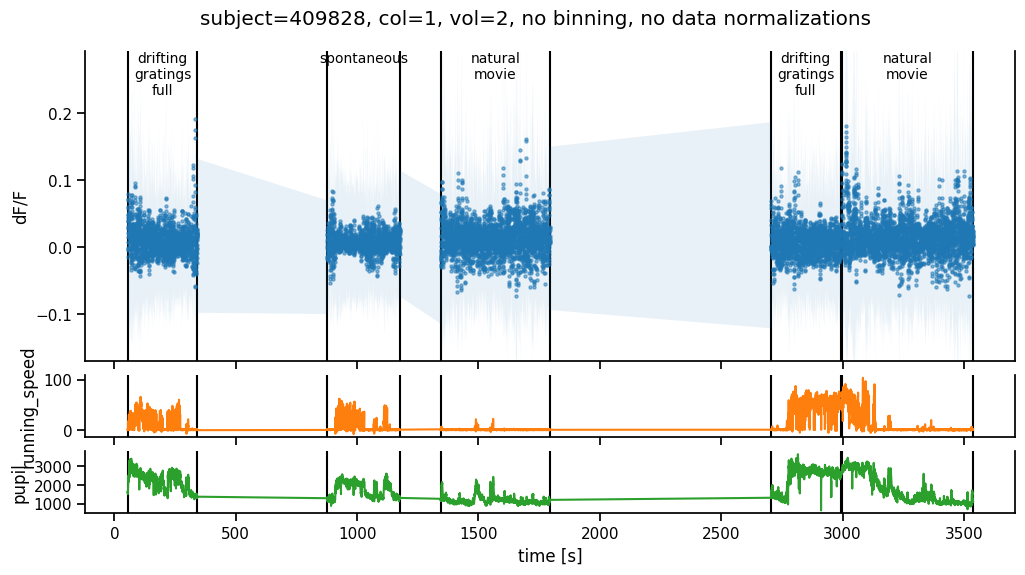

In [8]:
timestamps = selected_session_data['timestamps']
dff_avg = selected_session_data['dff_traces'].mean(axis=0)
dff_std = selected_session_data['dff_traces'].std(axis=0)
behavior_traces = selected_session_data['behavior_traces']
behavior_names = selected_session_data['behavior_names']

# ========================================================================
fig, axs = plt.subplots(
    nrows=3, height_ratios=[1,0.2,0.2], sharex=True,
    figsize=(12,6)
)
fig.subplots_adjust(hspace=0.1)

# -------------------------------------------------------------------------
# Row 1: Plot avg population trace
# -------------------------------------------------------------------------
ax = axs[0]
ax.scatter(timestamps, dff_avg, s=5, alpha=0.5, c='C0', label='df/F')
ax.fill_between(
    timestamps, dff_avg-dff_std, dff_avg+dff_std,
    color='C0', ec='none', alpha=0.1, zorder=1
)

ymin = np.percentile(dff_avg-dff_std, 1)
ymax = np.percentile(dff_avg+dff_std, 99)
ax.set_ylim(ymin,ymax)
ax.set_ylabel("dF/F")

# Add standard scaled behaviors
for i, (ax, name) in enumerate(zip(axs[1:], behavior_names)):
    ax.plot(timestamps, behavior_traces[i], color=f'C{i+1}')
    ax.set_ylabel(name)
    
    # ymin = np.percentile(behavior_traces[i], 2)
    # ymax = np.percentile(behavior_traces[i], 99)
    # ymin, ymax = -1.25, 5
    # ax.set_ylim(ymin,ymax)

# Plot stimulus epochs
for _, row in stim_epochs_df.iterrows():
    stim_name = row['stim_name']
    start_time = row['start_time']
    stop_time = row['stop_time']

    for ax in axs:
        ax.axvline(start_time, color='k', zorder=0)
        ax.axvline(stop_time, color='k', zorder=0)

        # Annotate
        if ax.get_subplotspec().is_first_row():
            xtext = 0.5*(stop_time-start_time) + start_time  # data coordinates
            ax.text(
                xtext, 1, '\n'.join(stim_name.split('_')), transform=ax.get_xaxis_transform(),
                ha='center', va='top', fontsize='small'
            )

# make pretty
ax.set_xlabel("time [s]")
ax.margins(x=0.0)

fig.suptitle(
    f'subject={selected_session.subject_id.item()}, '
    + f'col={selected_session.column.item()}, '
    + f'vol={selected_session.volume.item()}'
    + ', no binning, no data normalizations',
    y=0.95
)

sns.despine(right=False)

### dF/F and behavioral traces, with normalization

**Min-max scaling of dF/F**
We do a robust min-max scaling of the calcium imaging traces, between the 0.5-th to 99.5th percentiles.

In [9]:
for pct in [0, 0.5, 1, 5]:
    print(f"{pct} pct: {np.percentile(selected_session_data['dff_traces'], pct):.3f}")

print()
for pct in [95, 99, 99.5, 99.9, 100]:
    print(f"{pct} pct: {np.percentile(selected_session_data['dff_traces'], pct):.3f}")

0 pct: -0.528
0.5 pct: -0.203
1 pct: -0.180
5 pct: -0.122

95 pct: 0.156
99 pct: 0.334
99.5 pct: 0.557
99.9 pct: 1.306
100 pct: 5.925


In [10]:
def robust_min_max_scaler(arr, min_pct=0, max_pct=100, axis=0):
    min_val = np.percentile(arr, min_pct, axis=axis)
    max_val = np.percentile(arr, max_pct, axis=axis)

    return (arr-min_val) / (max_val-min_val)

from copy import deepcopy
normd_sel_session_data = deepcopy(selected_session_data)
normd_sel_session_data['dff_traces'] = robust_min_max_scaler(
    normd_sel_session_data['dff_traces'], 0.5, 99.9
)

# standard scale the behavioral data indepdently
normd_sel_session_data['behavior_traces'] = np.array([
    StandardScaler().fit_transform(trace[:,None]).squeeze() for trace in normd_sel_session_data['behavior_traces']
])

for k, v in normd_sel_session_data.items():
    print(f"{k}: {v.shape}")

timestamps: (11310,)
dff_traces: (2066, 11310)
plane_ids: (2066,)
roi_ids: (2066,)
behavior_traces: (2, 11310)
behavior_names: (2,)


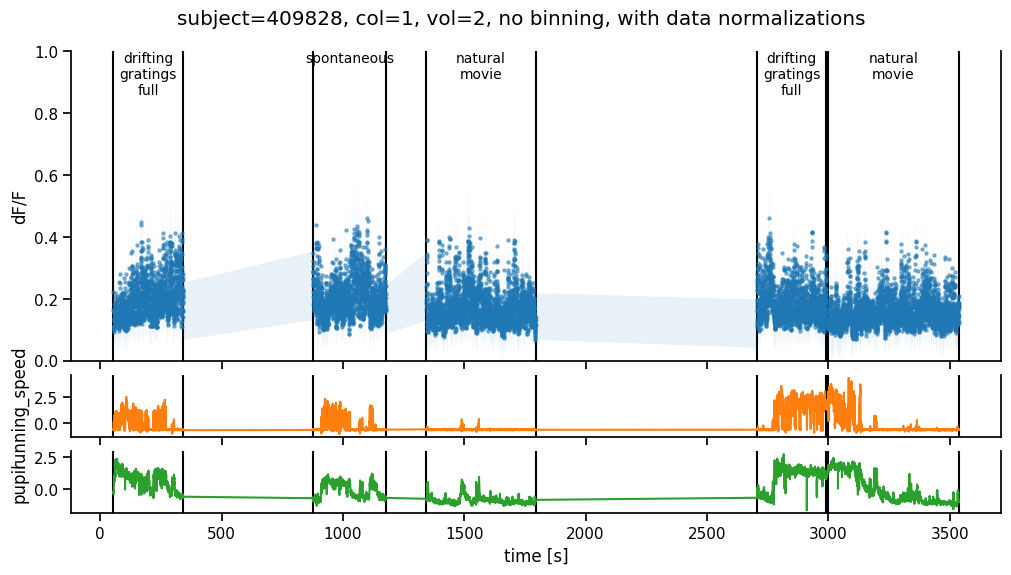

In [11]:
timestamps = normd_sel_session_data['timestamps']
dff_avg = normd_sel_session_data['dff_traces'].mean(axis=0)
dff_std = normd_sel_session_data['dff_traces'].std(axis=0)
behavior_traces = normd_sel_session_data['behavior_traces']
behavior_names = normd_sel_session_data['behavior_names']

# ========================================================================
fig, axs = plt.subplots(
    nrows=3, height_ratios=[1,0.2,0.2], sharex=True,
    figsize=(12,6)
)
fig.subplots_adjust(hspace=0.1)

# -------------------------------------------------------------------------
# Row 1: Plot avg population trace
# -------------------------------------------------------------------------
ax = axs[0]
ax.scatter(timestamps, dff_avg, s=5, alpha=0.5, c='C0', label='df/F')
ax.fill_between(
    timestamps, dff_avg-dff_std, dff_avg+dff_std,
    color='C0', ec='none', alpha=0.1, zorder=1
)

ax.set_ylim(0,1)
ax.set_ylabel("dF/F")

# Add standard scaled behaviors
for i, (ax, name) in enumerate(zip(axs[1:], behavior_names)):
    ax.plot(timestamps, behavior_traces[i], color=f'C{i+1}')
    ax.set_ylabel(name)
    
    # ymin = np.percentile(behavior_traces[i], 2)
    # ymax = np.percentile(behavior_traces[i], 99)
    # ymin, ymax = -1.25, 5
    # ax.set_ylim(ymin,ymax)

# Plot stimulus epochs
for _, row in stim_epochs_df.iterrows():
    stim_name = row['stim_name']
    start_time = row['start_time']
    stop_time = row['stop_time']

    for ax in axs:
        ax.axvline(start_time, color='k', zorder=0)
        ax.axvline(stop_time, color='k', zorder=0)

        # Annotate
        if ax.get_subplotspec().is_first_row():
            xtext = 0.5*(stop_time-start_time) + start_time  # data coordinates
            ax.text(
                xtext, 1, '\n'.join(stim_name.split('_')), transform=ax.get_xaxis_transform(),
                ha='center', va='top', fontsize='small'
            )

# make pretty
ax.set_xlabel("time [s]")
ax.margins(x=0.0)

fig.suptitle(
    f'subject={selected_session.subject_id.item()}, '
    + f'col={selected_session.column.item()}, '
    + f'vol={selected_session.volume.item()}'
    + ', no binning, with data normalizations',
    y=0.95
)

sns.despine(right=False)

### Bin by drifting gratings presentation

In [13]:
stimulus_table = nwb.intervals['stimulus_table'].to_dataframe()

selected_stimulus_table = stimulus_table[
    (stimulus_table['stim_name'] == 'drifting_gratings_full')
    & (stimulus_table['start_time'] <= 341.941071)  # Stop time of 1st epoch
]
selected_stimulus_table

,stim_name,start_time,stop_time,temporal_frequency,spatial_frequency,direction,frame,image_order,image_index,stimulus_condition_id
id,,,,,,,,,,
0,drifting_gratings_full,54.718670,56.703613,1.0,0.04,210.0,NaN,NaN,NaN,7
1,drifting_gratings_full,57.721142,59.706112,1.0,0.08,210.0,NaN,NaN,NaN,19
2,drifting_gratings_full,60.723713,62.708641,1.0,0.04,60.0,NaN,NaN,NaN,2
3,drifting_gratings_full,63.726173,65.711128,1.0,0.04,180.0,NaN,NaN,NaN,6
4,drifting_gratings_full,66.728699,68.713623,1.0,0.08,30.0,NaN,NaN,NaN,13
...,...,...,...,...,...,...,...,...,...,...
91,drifting_gratings_full,327.946075,329.931091,1.0,0.08,270.0,NaN,NaN,NaN,21
92,drifting_gratings_full,330.948578,332.933594,1.0,0.04,30.0,NaN,NaN,NaN,1
93,drifting_gratings_full,333.951080,335.936096,1.0,0.04,240.0,NaN,NaN,NaN,8


In [14]:
timestamps = normd_sel_session_data['timestamps']
dff_traces = normd_sel_session_data['dff_traces']
behavior_traces = normd_sel_session_data['behavior_traces']

# Now, let's bin them!
n_timebins = len(selected_stimulus_table)
binned_normd_sel_session_data = deepcopy(normd_sel_session_data)
binned_normd_sel_session_data['timestamps'] = selected_stimulus_table.start_time.values
binned_normd_sel_session_data['dff_traces'] = np.zeros((len(dff_traces), n_timebins))
binned_normd_sel_session_data['behavior_traces'] = np.zeros((len(behavior_traces), n_timebins))
for i, row in selected_stimulus_table.iterrows():
    start_time = row['start_time']
    stop_time = row['stop_time']

    mask = (timestamps >= start_time) & (timestamps <= stop_time)
    if len(mask) > 0:
        binned_normd_sel_session_data['dff_traces'][:,i] = np.mean(dff_traces[:,mask], axis=-1)
        binned_normd_sel_session_data['behavior_traces'][:,i] = np.mean(behavior_traces[:,mask], axis=-1)
    else:
        print(start_time, stop_time, 'empty mask')

for k, v in binned_normd_sel_session_data.items():
    print(f"{k}: {v.shape}")

timestamps: (96,)
dff_traces: (2066, 96)
plane_ids: (2066,)
roi_ids: (2066,)
behavior_traces: (2, 96)
behavior_names: (2,)


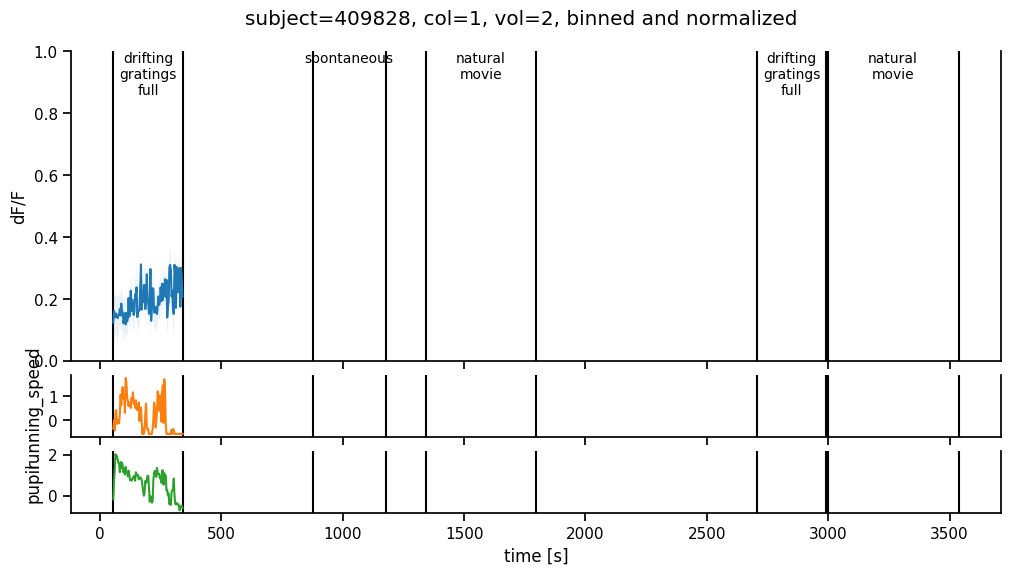

In [16]:
timestamps = binned_normd_sel_session_data['timestamps']
dff_avg = np.nanmean(binned_normd_sel_session_data['dff_traces'], axis=0)
dff_std = np.nanstd(binned_normd_sel_session_data['dff_traces'], axis=0)
behavior_traces = binned_normd_sel_session_data['behavior_traces']
behavior_names = binned_normd_sel_session_data['behavior_names']

# ========================================================================
fig, axs = plt.subplots(
    nrows=3, height_ratios=[1,0.2,0.2], sharex=True,
    figsize=(12,6)
)
fig.subplots_adjust(hspace=0.1)

# -------------------------------------------------------------------------
# Row 1: Plot avg population trace
# -------------------------------------------------------------------------
ax = axs[0]
ax.plot(timestamps, dff_avg, c='C0', label='df/F')
ax.fill_between(
    timestamps, dff_avg-dff_std, dff_avg+dff_std,
    color='C0', ec='none', alpha=0.1, zorder=1
)

ax.set_ylim(0,1)
ax.set_ylabel("dF/F")

# Add standard scaled behaviors
for i, (ax, name) in enumerate(zip(axs[1:], behavior_names)):
    ax.plot(timestamps, behavior_traces[i], color=f'C{i+1}')
    ax.set_ylabel(name)
    
    # ymin = np.percentile(behavior_traces[i], 2)
    # ymax = np.percentile(behavior_traces[i], 99)
    # ymin, ymax = -1.25, 5
    # ax.set_ylim(ymin,ymax)

# Plot stimulus epochs
for _, row in stim_epochs_df.iterrows():
    stim_name = row['stim_name']
    start_time = row['start_time']
    stop_time = row['stop_time']

    for ax in axs:
        ax.axvline(start_time, color='k', zorder=0)
        ax.axvline(stop_time, color='k', zorder=0)

        # Annotate
        if ax.get_subplotspec().is_first_row():
            xtext = 0.5*(stop_time-start_time) + start_time  # data coordinates
            ax.text(
                xtext, 1, '\n'.join(stim_name.split('_')), transform=ax.get_xaxis_transform(),
                ha='center', va='top', fontsize='small'
            )

# make pretty
ax.set_xlabel("time [s]")
ax.margins(x=0.0)

fig.suptitle(
    f'subject={selected_session.subject_id.item()}, '
    + f'col={selected_session.column.item()}, '
    + f'vol={selected_session.volume.item()}'
    + ', binned and normalized',
    y=0.95
)

sns.despine(right=False)

### Individual responses

Finally, let's take a look at the individual responses of each neuron in the normalized and binned case.

Text(0.5, 0.95, 'drifting_gratings_full, single neuron response, binned and normalized')

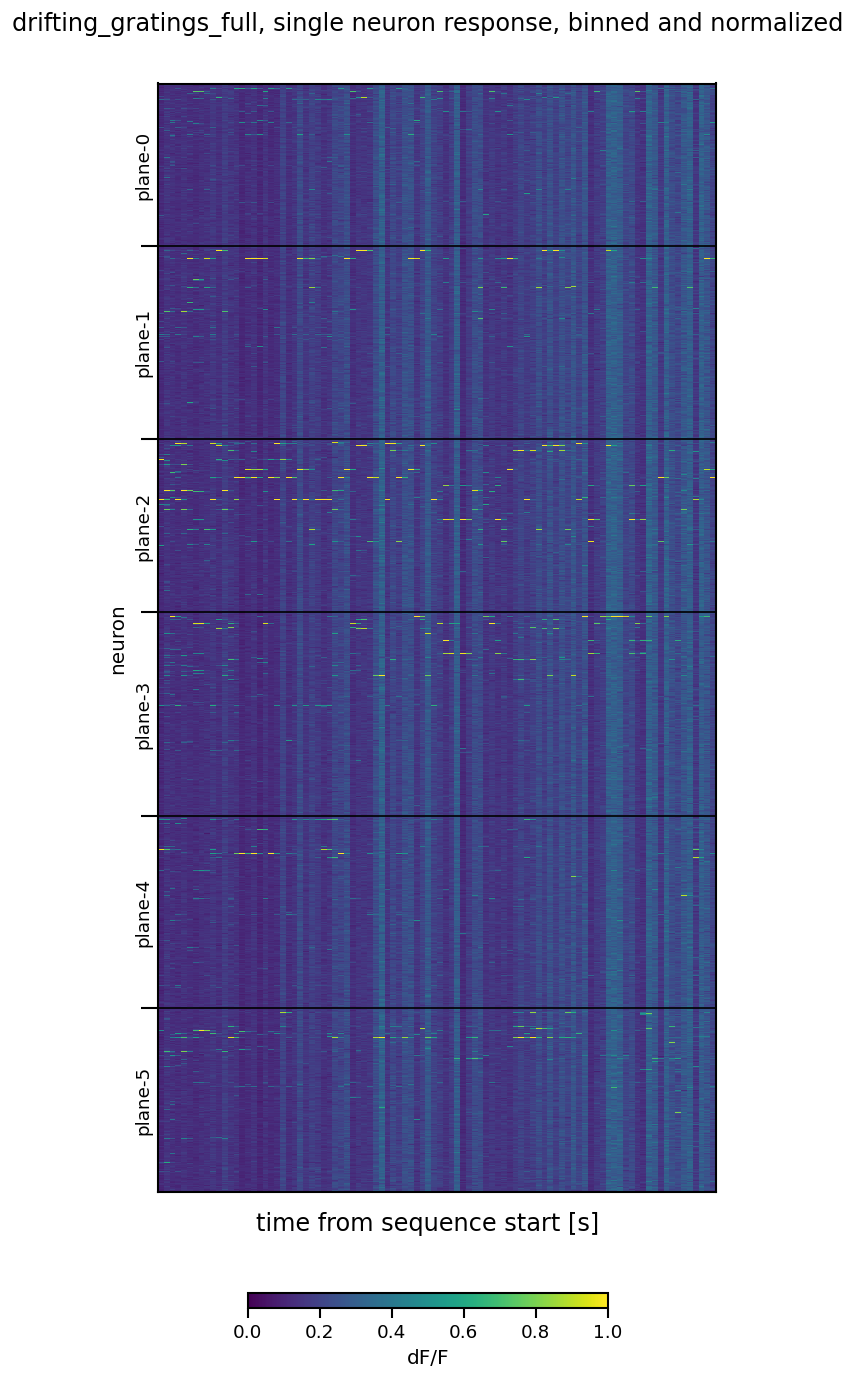

In [17]:
dff = binned_normd_sel_session_data['dff_traces']

# Set up drawing horizontal lines at every plane
plane_ids = binned_normd_sel_session_data['plane_ids']
y_cluster_edges = np.nonzero(plane_ids[1:] - plane_ids[:-1])[0] + 1

y_cluster_centers = np.concatenate([
    [0.5*y_cluster_edges[0]],  # first cluster
    0.5*(y_cluster_edges[1:] - y_cluster_edges[:-1]) + y_cluster_edges[:-1],
    [0.5*(len(plane_ids) - y_cluster_edges[-1]) + y_cluster_edges[-1]]  # last cluster
])

y_cluster_labels = [f'plane-{plane_id}' for plane_id in np.unique(plane_ids)]

# Set color norm
norm = mpl.colors.Normalize(vmin=0, vmax=1,)

fig, ax = plt.subplots(figsize=(6,12), dpi=120)
# for ax, start_index, stop_index in zip(axs, start_indices, stop_indices):
im = ax.imshow(dff, norm=norm, interpolation='none', aspect='auto')

for edge in y_cluster_edges:
    ax.axhline(edge, color='k', lw=1)

# Annotate y-axis with plane
ax.set_yticks(y_cluster_edges)
ax.tick_params(axis='y', labelleft=False, length=10)

ax.set_yticks(y_cluster_centers, minor=True)
ax.set_yticklabels(y_cluster_labels, minor=True, rotation=90, va='center',)
ax.tick_params(axis='y', which='minor', left=False, length=0)

# Hide x-axis ticks
ax.tick_params(labelbottom=False, bottom=False)

if ax.get_subplotspec().is_first_col():
    ax.set_ylabel('neuron')

fig.supxlabel("time from sequence start [s]", y=0.10)

# Add color bar
fig.subplots_adjust(top=0.9, bottom=0.13)
cax = fig.add_axes((0.25,0.05, 0.5, 0.01))   # (l,b,w,h)
fig.colorbar(im, cax=cax, label='dF/F', orientation='horizontal')

# Add title
fig.suptitle("drifting_gratings_full, single neuron response, binned and normalized", y=0.95)